<a href="https://colab.research.google.com/github/Antony-gitau/Airline_ticket_price_prediction/blob/main/Copy_of_BALITU_Assignment_2_Exercise_2_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BALITU Assignment 2 Exercise 2

$$
\require{mathtools}
\DeclareMathOperator{\opExpectation}{\mathbb{E}}
\newcommand{\E}[2]{\opExpectation_{#1} \left [ #2 \right ]}
\newcommand{\simpleE}[1]{\opExpectation_{#1}}
\newcommand{\implicitE}[1]{\opExpectation \left [ #1 \right ]}
\DeclareMathOperator{\opVar}{\mathrm{Var}}
\newcommand{\Var}[2]{\opVar_{#1} \left [ #2 \right ]}
\newcommand{\implicitVar}[1]{\opVar \left [ #1 \right ]}
\newcommand\MidSymbol[1][]{%
\:#1\:}
\newcommand{\given}{\MidSymbol[\vert]}
\DeclareMathOperator{\opmus}{\mu^*}
\newcommand{\IMof}[1]{\opmus[#1]}
\DeclareMathOperator{\opInformationContent}{H}
\newcommand{\ICof}[1]{\opInformationContent[#1]}
\newcommand{\xICof}[1]{\opInformationContent(#1)}
\newcommand{\sicof}[1]{h(#1)}
\DeclareMathOperator{\opEntropy}{H}
\newcommand{\Hof}[1]{\opEntropy[#1]}
\newcommand{\xHof}[1]{\opEntropy(#1)}
\DeclareMathOperator{\opMI}{I}
\newcommand{\MIof}[1]{\opMI[#1]}
\DeclareMathOperator{\opTC}{TC}
\newcommand{\TCof}[1]{\opTC[#1]}
\newcommand{\CrossEntropy}[2]{\opEntropy(#1 \MidSymbol[\Vert] #2)}
\DeclareMathOperator{\opKale}{D_\mathrm{KL}}
\newcommand{\Kale}[2]{\opKale(#1 \MidSymbol[\Vert] #2)}
\DeclareMathOperator{\opJSD}{D_\mathrm{JSD}}
\newcommand{\JSD}[2]{\opJSD(#1 \MidSymbol[\Vert] #2)}
\DeclareMathOperator{\opp}{p}
\newcommand{\pof}[1]{\opp(#1)}
\newcommand{\pcof}[2]{\opp_{#1}(#2)}
\newcommand{\hpcof}[2]{\hat\opp_{#1}(#2)}
\DeclareMathOperator{\opq}{q}
\newcommand{\qof}[1]{\opq(#1)}
\newcommand{\qcof}[2]{\opq_{#1}(#2)}
\newcommand{\varHof}[2]{\opEntropy_{#1}[#2]}
\newcommand{\xvarHof}[2]{\opEntropy_{#1}(#2)}
\newcommand{\varMIof}[2]{\opMI_{#1}[#2]}
\newcommand{\w}{\boldsymbol{\omega}}
\newcommand{\W}{\boldsymbol{\Omega}}
\DeclareMathOperator{\opf}{f}
\newcommand{\fof}[1]{\opf(#1)}
\newcommand{\indep}{\perp\!\!\!\!\perp}
$$

## 2. Comparing Uncertainty Methods (25p)

We will use a LeNet5 model \[@lecun1998gradient\] with additional
dropout layers as model architecture and MNIST and
[Dirty-MNIST](https://blackhc.github.io/ddu_dirty_mnist/) as datasets
for the following experiments. Dirty-MNIST is a version of MNIST with
additional ambiguous samples.

For the Laplace approximation, we can use the [laplace
package](https://aleximmer.github.io/Laplace/). For MC dropout, we can
enable dropout during evaluation and simply average the predictions of
multiple forward passes with different dropout masks.

To compute BALD, use 32 samples for MC dropout and the Laplace
approximation and 8 models for the deep ensemble.

To compare the methods, we will use rejection classification based on
epistemic uncertainty: **Classification with a rejection option**
thresholds the epistemic uncertainty for the predictions we accept and
computes the evaluation metrics only for the accepted predictions. We
plot the rejection percentile vs. the performance metric. As we vary the
threshold, we get a trade-off between performance and rejection rate.
Ideally, the fewer predictions we accept, the better the performance.

#### Tasks:

1. **(8p)** Train models on Dirty-MNIST's training set and evaluate NLL and accuracy on MNIST's test set using the following methods:
   
   1. Deep Ensembles
   2. MC Dropout
   3. Laplace Approximation (**strongly optional**)
   4. Deterministic Model (no dropout during evaluation)
   
   *Use a convolutional dropout layer after each convolutional layer and a regular dropout layer after each linear layer with dropout probability 0.5. For Deep Ensembles, train 8 models with different random initializations. For the Laplace Approximation, use the recommended defaults from the laplace package. For all methods, use the Adam optimizer with a learning rate of 0.001 and weight decay of 5e-4 and train for 10 epochs.*

In [1]:
# Install dirty-mnist via `pip install ddu_dirty_mnist` or similar.
%%capture
!pip install ddu_dirty_mnist
!pip install laplace-torch

In [2]:
# Imports & Setup

# set PYTORCH_ENABLE_MPS_FALLBACK environment variable to 1 to use MPS (no effect on CUDA)
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from typing import Callable, Optional

import ddu_dirty_mnist
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

In [3]:
# LeNet5 with additional dropout layers for MNIST

class BayesianMNISTCNN(nn.Module):
    """LeNet5 with additional dropout layers."""

    def __init__(self, num_classes=10, p=0.5):
        super(BayesianMNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.dropout1 = nn.Dropout2d(p=p)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.dropout2 = nn.Dropout2d(p=p)
        self.fc1 = nn.Linear(in_features=1024, out_features=128)
        self.dropout3 = nn.Dropout(p=p)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x, _ = F.max_pool2d(x, kernel_size=2, return_indices=True)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x, _ = F.max_pool2d(x, kernel_size=2, return_indices=True)
        x = self.dropout2(x)

        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)

        embedding = x
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output, embedding


def create_model_optimizer() -> tuple[BayesianMNISTCNN, torch.optim.Optimizer]:
    """Create a model and optimizer for MNIST."""
    model = BayesianMNISTCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    return model, optimizer

In [4]:
def get_data_loaders(batch_size=64, eval_batch_size=1024, device="cuda"):
    train_dataset = ddu_dirty_mnist.DirtyMNIST('./data', train=True, download=True, device=device, normalize=True)
    test_dataset_mnist = ddu_dirty_mnist.FastMNIST('./data', train=False, download=True, device=device, normalize=True)
    test_dataset_dirty_mnist = ddu_dirty_mnist.DirtyMNIST('./data', train=False, download=True, device=device, normalize=True)
    test_dataset_fashion = datasets.FashionMNIST('./data', train=False, download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=eval_batch_size, shuffle=False, num_workers=0)
    test_loader_dirty_mnist = DataLoader(test_dataset_dirty_mnist, batch_size=eval_batch_size, shuffle=False, num_workers=0)
    test_loader_fashion = DataLoader(test_dataset_fashion, batch_size=eval_batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader_mnist, test_loader_dirty_mnist, test_loader_fashion

In [5]:
%%capture
train_loader, test_loader_mnist, test_loader_dirty_mnist, test_loader_fashion = get_data_loaders()

#### TODOs:

1.  Define a training loop to train a model
2.  Train a deep ensemble of 8 models
3.  Define a function to predict log probabilities with a deep ensemble
    (make sure to use eval mode and average over the ensemble
    predictions)
4.  Evaluate the deep ensemble on MNIST’s test set in terms of NLL and
    accuracy

Use one of the trained models to predict log probabilities with MC
Dropout (make sure to use train mode to get different predictions for
each sample).

# Training loop

In [6]:
def train_model(model, train_loader, optimizer, device, epoch):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output, _ = model(data)
        loss = F.nll_loss(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    if epoch % 5 == 0:
      print(f'Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    return epoch_loss, epoch_accuracy


In [7]:
def train_ensemble(train_loader, device, num_models=8, epochs=10):
    ensemble = []
    for i in range(num_models):
        model, optimizer = create_model_optimizer()
        model = model.to(device)
        print(f"Training model {i+1}")
        for epoch in range(1, epochs + 1):
            train_loss, train_accuracy = train_model(model, train_loader, optimizer, device, epoch)
        ensemble.append(model)
    return ensemble


In [8]:
def predict_ensemble(models, data, device):
    models = [model.to(device) for model in models]
    log_probs_list = []

    for model in models:
        model.eval()  # Set each model to eval mode
        with torch.no_grad():
            output, _ = model(data)
            log_probs_list.append(output)

    # Average the log-probabilities
    avg_log_probs = torch.mean(torch.stack(log_probs_list), dim=0)
    return avg_log_probs


In [9]:
def evaluate_ensemble(models, test_loader, device):
    models = [model.to(device) for model in models]
    for model in models:
      model.eval()

    test_loss = 0
    correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Get the average log probabilities from the ensemble
        avg_log_probs = predict_ensemble(models, data, device)

        # Compute the loss
        loss = F.nll_loss(avg_log_probs, target)
        test_loss += loss.item()

        # Calculate accuracy
        pred = avg_log_probs.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return test_loss, accuracy


In [10]:
def predict_mc_dropout(model, data, device, num_samples=32):
    model.train()  # Keep the model in training mode to apply dropout
    log_probs_list = []

    for _ in range(num_samples):
        with torch.no_grad():
            output, _ = model(data)
            log_probs_list.append(output)

    # Average the predictions across all samples
    avg_log_probs = torch.mean(torch.stack(log_probs_list), dim=0)
    return avg_log_probs


In [11]:
# Train the ensemble
ensemble = train_ensemble(train_loader, device, num_models=2, epochs=10)

# Evaluate the ensemble
test_loss, accuracy = evaluate_ensemble(ensemble, test_loader_mnist, device)
print(f"Ensemble Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Use one model to predict log probabilities with MC Dropout
model = ensemble[0]
sample_data, _ = next(iter(test_loader_mnist))
sample_data = sample_data.to(device)

mc_log_probs = predict_mc_dropout(model, sample_data, device, num_samples=100)
print(f"MC Dropout Log Probabilities: {mc_log_probs}")



Training model 1
Epoch 5: Loss: 0.4439, Accuracy: 85.02%
Epoch 10: Loss: 0.4317, Accuracy: 85.36%
Training model 2
Epoch 5: Loss: 0.4437, Accuracy: 85.07%
Epoch 10: Loss: 0.4316, Accuracy: 85.47%
Ensemble Test Loss: 0.0417, Test Accuracy: 98.88%
MC Dropout Log Probabilities: tensor([[-1.9450e+01, -1.4247e+01, -1.1915e+01,  ..., -6.2905e-03,
         -1.9968e+01, -1.0948e+01],
        [-9.7600e+00, -1.0256e+01, -1.0720e-02,  ..., -1.6653e+01,
         -1.2531e+01, -2.0875e+01],
        [-1.1687e+01, -1.7274e-02, -8.8738e+00,  ..., -7.7216e+00,
         -7.7007e+00, -1.1049e+01],
        ...,
        [-1.3384e+01, -8.1412e+00, -5.9580e+00,  ..., -9.9419e-02,
         -9.9232e+00, -1.1079e+01],
        [-1.9953e+01, -2.3487e+01, -2.0622e+01,  ..., -1.5842e+01,
         -1.1987e+01, -5.4101e+00],
        [-1.9690e+01, -1.3869e+01, -1.3081e+01,  ..., -9.1272e+00,
         -1.7057e+01, -1.2533e+01]], device='cuda:0')


In [12]:
@torch.inference_mode()
def deep_ensembles_predict_log_probs(models: list[BayesianMNISTCNN], data_loader: DataLoader, device='cuda') -> torch.Tensor:
    """Predict log probabilities with Deep Ensembles.

    Args:
        models: List of models
        data_loader: DataLoader for the data to predict
        device: Device to use for prediction

    Returns:
        Tensor of shape (n_models, n_inputs, n_classes) containing log_softmax outputs
    """
    for model in models:
        model.to(device)
        model.eval()
    all_outputs = []
    for data, _ in tqdm(data_loader, desc="Predicting with Deep Ensembles"):
        data = data.to(device)
        outputs = []
        for model in models:
            log_probs, _ = model(data)
            outputs.append(log_probs)
        all_outputs.append(torch.stack(outputs, dim=0))
    return torch.cat(all_outputs, dim=1)

# function to predict log probabilities with a deep ensemble

In [13]:
log_probabs = deep_ensembles_predict_log_probs(ensemble, test_loader_mnist)

Predicting with Deep Ensembles: 100%|██████████| 10/10 [00:00<00:00, 118.84it/s]


In [14]:
log_probabs.shape

torch.Size([2, 10000, 10])

# evaluate NLL and accuracy on MNIST's test set

In [15]:
from typing import Callable, Optional, Tuple
def compute_performance_metrics(log_probs: torch.Tensor, data_loader: DataLoader) -> Tuple[float, float]:
    """Compute accuracy and negative log likelihood metrics.

    Args:
        log_probs: Tensor of shape (n_samples, n_inputs, n_classes) containing log_softmax outputs
        data_loader: DataLoader containing the data and labels

    Returns:
        Tuple of (accuracy, negative log likelihood)
    """
    device = log_probs.device

    # Average predictions over samples
    mean_log_probs = torch.logsumexp(log_probs, dim=0) - torch.log(torch.tensor(log_probs.shape[0], device=device))

    all_labels = []
    for _, labels in data_loader:
        all_labels.append(labels)
    labels = torch.cat(all_labels).to(device)

    # Compute accuracy
    predictions = mean_log_probs.argmax(dim=1)
    accuracy = (predictions == labels).float().mean().item()

    # Compute negative log likelihood
    nll = -mean_log_probs[range(len(labels)), labels].mean().item()

    return accuracy, nll

In [16]:
accuracy, nll = compute_performance_metrics(log_probabs, test_loader_mnist)
accuracy, nll

(0.9884999990463257, 0.03942388668656349)

In [17]:
from laplace import Laplace, ParametricLaplace
from laplace.curvature.curvlinops import CurvlinopsGGN

def apply_laplace_approximation(model, train_loader, device='cuda') -> ParametricLaplace:
    """Apply the Laplace approximation to a model.

    Args:
        model: Model to approximate
        train_loader: DataLoader for the training data
        device: Device to use for prediction

    Returns:
        Fitted Laplace approximation
    """
    model.to(device)
    model.train()
    la: ParametricLaplace = Laplace(model,
                 likelihood='classification',
                 subset_of_weights='all',
                 hessian_structure='gp',
                 backend=CurvlinopsGGN,
                 n_subset=1024)
    la.fit(train_loader, progress_bar=True)
    la.optimize_prior_precision(progress_bar=True)
    return la

In [18]:
class ModelWrapper(nn.Module):
    """Wrapper to convert a BayesianMNISTCNN to a model that can be used with the Laplace approximation."""
    model: BayesianMNISTCNN

    def __init__(self, model: BayesianMNISTCNN):
        super().__init__()
        self.model = model

    def forward(self, x):
        self.model.eval()

        _, embedding = self.model(x)
        logits = self.model.fc2(embedding)
        return logits

In [19]:
def laplace_approximation_predict_log_probs(la: ParametricLaplace, data_loader: DataLoader, num_parameter_samples=32, device='cuda') -> torch.Tensor:
    """Predict log probabilities with Laplace Approximation.

    Args:
        la: Fitted Laplace approximation
        data_loader: DataLoader for the data to predict
        num_parameter_samples: Number of Monte Carlo samples
        device: Device to use for prediction

    Returns:
        Tensor of shape (n_samples, n_inputs, n_classes) containing log_softmax outputs
    """
    la.model.to(device)
    la.model.eval()
    all_outputs = []
    for data, _ in tqdm(data_loader, desc="Predicting with Laplace Approximation"):
        data = data.to(device)
        samples = la.predictive_samples(data, n_samples=num_parameter_samples)
        all_outputs.append(samples.log())
    return torch.cat(all_outputs, dim=1)

2. **(5p)** Implement classification with a rejection option for Dirty-MNIST's test set using the models you have trained on Dirty-MNIST and implement BALD as proxy for epistemic uncertainty and compare it to using predictive entropy and conditional entropy (as aleatoric uncertainty).
   
   *Hint: For the deterministic model, you can only compute the the predictive entropy. For MC dropout and Laplace approximation, you can estimate the predictive entropy using samples from the posterior. For deep ensembles, you likewise can use the empirical distribution over the ensemble predictions to estimate the predictive entropy. Then, the epistemic uncertainty (BALD) can be estimated as the difference between the expected entropy and the entropy of the expected predictive distribution.*

3. **(2p)** Plot epistemic uncertainty percentiles vs. the performance (NLL and accuracy) for the rejection option. How do the different methods perform? *Hint: You should observe that as you increase the rejection percentile (i.e., reject more samples), the performance on the remaining samples improves.*

4. **(4p)** Implement OoD detection on Dirty-MNIST vs. Fashion-MNIST using epistemic uncertainty (BALD) and aleatoric uncertainty (predictive entropy and conditional entropy) for your different models. Plot the ROC curve that and report the AUROC. How do the different methods perform? *Hint: You can use `sklearn.metrics.RocCurveDisplay.from_predictions` to help plot the ROC curve and compute the AUROC. Create artifical labels of 0 for Dirty-MNIST samples and 1 for Fashion-MNIST samples and pass them with the uncertainty values to `RocCurveDisplay.from_predictions` to plot the ROC curve for each method and uncertainty metric.*
   
   _Note: Total uncertainty worked best for me and epistemic uncertainy did not work that well---no idea why._

In [20]:
def predictive_entropy(logits):
    probs = F.softmax(logits, dim=1)
    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
    return entropy

# Bayesian Active Learning by Disagreement
def bald(logits_samples):
    expected_logits = logits_samples.mean(dim=0)
    expected_probs = F.softmax(expected_logits, dim=1)

    expected_entropy = -torch.sum(expected_probs * torch.log(expected_probs + 1e-10), dim=1)

    individual_entropies = torch.mean(torch.stack([predictive_entropy(sample) for sample in logits_samples]), dim=0)

    bald_value = expected_entropy - individual_entropies
    return bald_value

def ensemble_predictive_entropy(models, data, num_samples=10):
    logits_samples = []
    for model in models:
        model.eval()
        with torch.no_grad():
            # Perform MC Dropout by passing the data multiple times through the model
            sample_logits = []
            for _ in range(num_samples):
                logits = model(data)[0]
                sample_logits.append(logits)
            logits_samples.append(torch.stack(sample_logits))

    logits_samples = torch.stack(logits_samples)  # Shape: [ensemble_size, num_samples, batch_size, num_classes]
    return bald(logits_samples)

# rejection criterion based on uncertainty
def reject_classification(uncertainty, threshold):
    return uncertainty.mean() > threshold


In [21]:
def classify_with_rejection(models, test_loader, threshold=0.5, use_bald=True, num_samples=100):
    model = models[1]  # choosing a model from ensemble
    model.eval()

    correct = 0
    total = 0
    rejected = 0

    all_logits = []

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)

        if use_bald:
            # Use ensemble to compute BALD as a proxy for epistemic uncertainty
            uncertainty = ensemble_predictive_entropy(models, data, num_samples)
            logits = model(data)[0]
        else:
            # For a deterministic model, calculate predictive entropy
            logits = model(data)[0]
            uncertainty = predictive_entropy(logits)

        for i in range(len(uncertainty)):
            # Check if the uncertainty is above the threshold for rejection
            if reject_classification(uncertainty[i], threshold):
                rejected += 1
                continue  # Skip this sample if rejected

            # If not rejected, classify the sample
            _, predicted = torch.max(logits[i], dim=0)
            if predicted == target[i]:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0
    rejection_rate = rejected / len(test_loader.dataset)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Rejection Rate: {rejection_rate * 100:.2f}%")
    return accuracy, rejection_rate


In [22]:
# rejection threshhold
threshold = 0.5
accuracy, rejection_rate = classify_with_rejection(ensemble, test_loader_dirty_mnist, threshold=threshold, use_bald=False)

Accuracy: 96.01%
Rejection Rate: 52.75%


In [30]:
# rejection threshhold
threshold = 0.5
accuracy2, rejection_rate2 = classify_with_rejection(ensemble, test_loader_dirty_mnist, threshold=threshold, use_bald=True)

Accuracy: 82.04%
Rejection Rate: 0.00%


In [23]:
def compute_accuracy_metric(predictive_log_probs: torch.Tensor, labels: torch.Tensor) -> float:
    """Compute accuracy for given predictions and labels."""
    predictions = predictive_log_probs.argmax(dim=1)
    return (predictions == labels).float().mean().item()

def compute_nll_metric(predictive_log_probs: torch.Tensor, labels: torch.Tensor) -> float:
    """Compute negative log likelihood for given predictions and labels."""
    return -predictive_log_probs[range(len(labels)), labels].mean().item()

def plot_rejection_curve(
    uncertainties: torch.Tensor,
    predictive_log_probs: torch.Tensor,
    labels: torch.Tensor,
    method_name: str,
    performance_metric: Callable[[torch.Tensor, torch.Tensor], float] = compute_accuracy_metric,
    metric_name: str = "Accuracy",
    num_bins: int = 20,
    ax: Optional[plt.Axes] = None,
    device: str = "cuda"
) -> tuple[np.ndarray, np.ndarray]:
    """Plot performance metric vs rejection rate curve.

    Args:
        uncertainties: Tensor of uncertainty scores for each sample
        predictive_log_probs: Predicted log probabilities (n_inputs, n_classes)
        data_loader: DataLoader containing the evaluation data
        method_name: Name of the method for the legend
        performance_metric: Callable that computes the metric given log_probs and labels
        metric_name: Name of the metric for the y-axis
        num_bins: Number of bins for smoothing
        ax: Matplotlib axes to plot on
        device: Device to use for computations

    Returns:
        Tuple of (rejection_rates, metric_values) arrays
    """
    # Sort samples by uncertainty (highest to lowest)
    sorted_indices = torch.argsort(uncertainties).to(device)
    sorted_predictive_log_probs = predictive_log_probs.to(device)[sorted_indices]
    sorted_labels = labels.to(device)[sorted_indices]

    # Calculate rejection rates and metric values
    total_samples = uncertainties.shape[0]
    rejection_rates = np.linspace(0, 1, num_bins)
    metric_values = []

    for rate in rejection_rates:
        num_kept = int(total_samples * (1 - rate))
        if num_kept > 0:
            metric_value = performance_metric(
                sorted_predictive_log_probs[:num_kept],
                sorted_labels[:num_kept]
            )
        else:
            metric_value = 1.0 if metric_name == "Accuracy" else 0.0
        metric_values.append(metric_value)

    # Create plot
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))

    ax.plot(rejection_rates * 100, metric_values, label=method_name, marker='o', markersize=4)
    ax.set_xlabel('Rejection Rate (%)')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} vs Rejection Rate')
    ax.grid(True, alpha=0.3)
    ax.legend()

    return rejection_rates, np.array(metric_values)

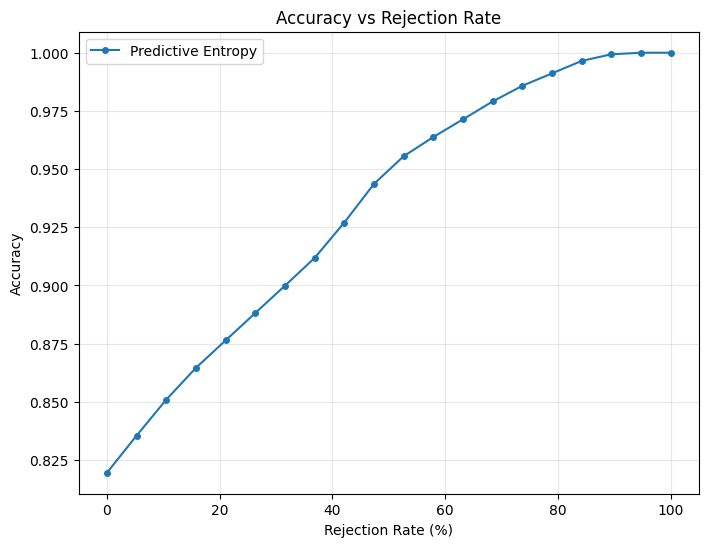

In [24]:
all_logits = []
all_labels = []
all_uncertainties = []

for data, labels in test_loader_dirty_mnist:
    data = data.to(device)
    labels = labels.to(device)

    logits = model(data)[0]
    uncertainties = predictive_entropy(logits)

    all_logits.append(logits)
    all_labels.append(labels)
    all_uncertainties.append(uncertainties)


# Concatenate all the collected data
all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_uncertainties = torch.cat(all_uncertainties, dim=0)

# Now, plot the rejection curve using the uncertainties and logits from this batch:
rejection_rates, accuracy_values = plot_rejection_curve(
    uncertainties=all_uncertainties,
    predictive_log_probs=all_logits,
    labels=all_labels,  # Use the labels from this batch
    method_name="Predictive Entropy",
    performance_metric=compute_accuracy_metric,
    metric_name="Accuracy",
    num_bins=20,
    device=device
)

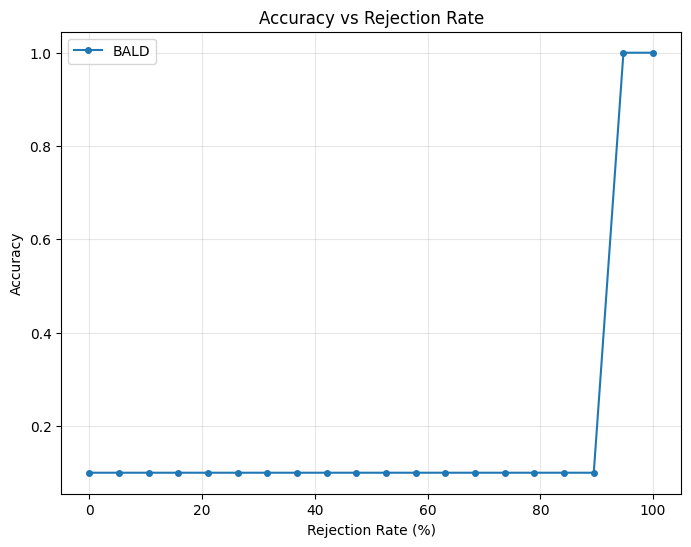

In [25]:
uncertainties = ensemble_predictive_entropy(ensemble, data)

# Now, plot the rejection curve
rejection_rates, accuracy_values = plot_rejection_curve(
    uncertainties=uncertainties,
    predictive_log_probs=logits,
    labels=labels,
    method_name="BALD",
    performance_metric=compute_accuracy_metric,
    metric_name="Accuracy",
    num_bins=20,
    device="cuda"
)


In [31]:
# Function to calculate conditional entropy
def conditional_entropy(logits_samples):
    expected_logits = logits_samples.mean(dim=0)
    expected_probs = F.softmax(expected_logits, dim=1)
    expected_entropy = -torch.sum(expected_probs * torch.log(expected_probs + 1e-10), dim=1)

    individual_entropies = torch.mean(torch.stack([predictive_entropy(sample) for sample in logits_samples]), dim=0)

    return individual_entropies - expected_entropy

In [36]:
# Function to calculate uncertainties for a batch of data
def compute_uncertainties(model, data, num_samples=10):
    model.eval()
    all_logits_samples = []
    for _ in range(num_samples):
        with torch.no_grad():
            logits = model(data)[0]
            all_logits_samples.append(logits)

    logits_samples = torch.stack(all_logits_samples)
    predictive_entropy_values = predictive_entropy(logits_samples.mean(dim=0))
    conditional_entropy_values = conditional_entropy(logits_samples)
    bald_values = bald(logits_samples)

    return predictive_entropy_values, conditional_entropy_values,  bald_values

In [38]:
bald_values.shape, predictive_entropy_values.shape, conditional_entropy_values.shape

((70000,), (70000,), (70000,))

In [46]:
# Create uncertainty lists for both datasets
predictive_entropy_values_dirty = []
conditional_entropy_values_dirty = []
bald_values_dirty = []

predictive_entropy_values_fashion = []
conditional_entropy_values_fashion = []
bald_values_fashion = []

# Loop over Dirty-MNIST
for data, labels in test_loader_dirty_mnist:
    data = data.to(device)
    # Compute uncertainties for this batch
    pred_entropy, cond_entropy, bald_val = compute_uncertainties(model, data)

    predictive_entropy_values_dirty.append(pred_entropy.cpu().numpy())
    conditional_entropy_values_dirty.append(cond_entropy.cpu().numpy())
    bald_values_dirty.append(bald_val.cpu().numpy())

# Loop over Fashion-MNIST
for data, labels in test_loader_fashion:
    data = data.to(device)
    # Compute uncertainties for this batch
    pred_entropy, cond_entropy, bald_val = compute_uncertainties(model, data)

    predictive_entropy_values_fashion.append(pred_entropy.cpu().numpy())
    conditional_entropy_values_fashion.append(cond_entropy.cpu().numpy())
    bald_values_fashion.append(bald_val.cpu().numpy())

# Concatenate the uncertainties for each dataset
predictive_entropy_values = np.concatenate([np.concatenate(predictive_entropy_values_dirty),
                                            np.concatenate(predictive_entropy_values_fashion)])
conditional_entropy_values = np.concatenate([np.concatenate(conditional_entropy_values_dirty),
                                             np.concatenate(conditional_entropy_values_fashion)])
bald_values = np.concatenate([np.concatenate(bald_values_dirty),
                               np.concatenate(bald_values_fashion)])


In [47]:
predictive_entropy_values.shape, conditional_entropy_values.shape, bald_values.shape

((80000,), (80000,), (80000,))

<Figure size 1000x800 with 0 Axes>

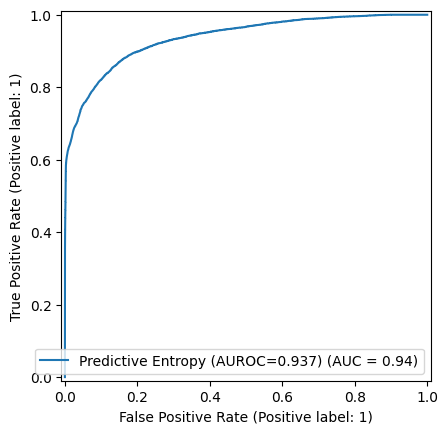

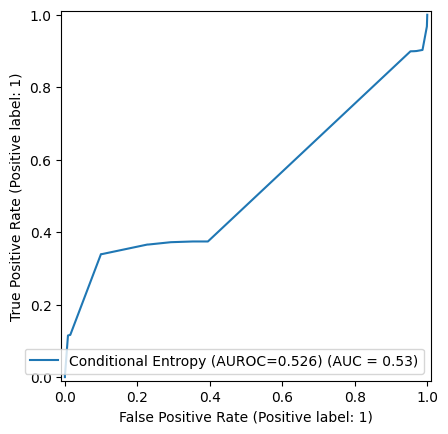

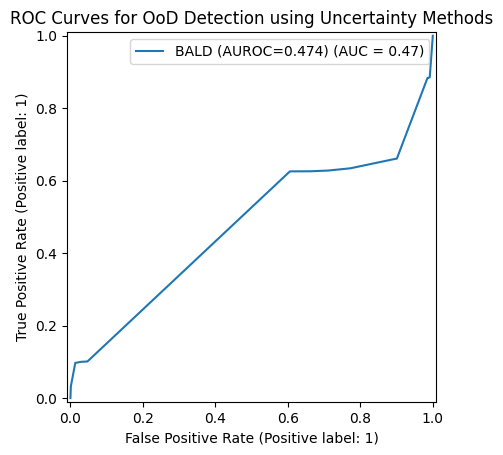

In [48]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Combine all uncertainty values for plotting
uncertainty_values = {
    'Predictive Entropy': predictive_entropy_values,
    'Conditional Entropy': conditional_entropy_values,
    'BALD': bald_values
}

# Extract labels from data loaders
dirty_mnist_labels = []
for _, labels in test_loader_dirty_mnist:
    dirty_mnist_labels.extend(labels.cpu().numpy())
dirty_mnist_labels = np.array(dirty_mnist_labels)

fashion_mnist_labels = []
for _, labels in test_loader_fashion:
    fashion_mnist_labels.extend(labels.cpu().numpy())
fashion_mnist_labels = np.array(fashion_mnist_labels)

# Create artificial labels: 0 for Dirty-MNIST, 1 for Fashion-MNIST
dirty_mnist_ood_labels = np.zeros_like(dirty_mnist_labels)
fashion_mnist_ood_labels = np.ones_like(fashion_mnist_labels)

# Concatenate labels for ROC analysis
labels = np.concatenate([dirty_mnist_ood_labels, fashion_mnist_ood_labels])

# Plot ROC curves for each uncertainty metric
plt.figure(figsize=(10, 8))
for method, uncertainties in uncertainty_values.items():
    # Compute AUROC
    auc = roc_auc_score(labels, uncertainties)
    RocCurveDisplay.from_predictions(labels, uncertainties, name=f"{method} (AUROC={auc:.3f})")

# Show the plot
plt.title('ROC Curves for OoD Detection using Uncertainty Methods')
plt.legend()
plt.show()


5.  **(Optional 10p)** Implement density-based uncertainty estimation
    (e.g., using Mahalanobis distance) and compare its performance to
    the other methods: train a single model (or take one of the trained
    models) and extract the latents (activations before the last layer)
    and predictions on MNIST’s training set. Fit a Gaussian distribution
    for each class (using the class predictions as weights on the
    latents if you want to) using the training set. At test time, we can
    estimate the epistemic uncertainty via the sample density in latent
    space by taking the latent and computing the sum of the densities
    under the class-specific Gaussians. How does the performance of this
    compare to the other methods when we evaluate on Dirty-MNIST using
    classification with a rejection option? *Hint: You can use
    `sklearn.covariance.EmpiricalCovariance` or
    `sklearn.covariance.MinCovDet` to estimate the covariance matrix for
    each class. Remember to regularize the covariance matrix to avoid
    numerical issues. You can also use the `store_precision` options to
    store the precision matrix instead of the covariance matrix. For
    numerical stability, add a small multiple of the identity matrix to
    the covariance matrix (e.g., `1e-12 * np.eye(latent_dim)`).*